In [6]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("wafaaelhusseini/capital-weather-data-1995-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'capital-weather-data-1995-2024' dataset.
Path to dataset files: /kaggle/input/capital-weather-data-1995-2024


In [9]:
path = "/root/.cache/kagglehub/datasets/wafaaelhusseini/capital-weather-data-1995-2024/versions/29"
files = os.listdir(path)
print("Files in dataset:", files)

df = pd.read_parquet(path)
df.head()
df.columns


Files in dataset: ['history.parquet']


Index(['date', 'country', 'country_alpha2', 'capital', 'lat', 'lon',
       'temp_min_c', 'temp_max_c', 'temp_mean_c_approx', 'app_temp_min_c',
       'app_temp_max_c', 'precip_mm', 'rain_mm', 'snow_mm',
       'windspeed_10m_max_kmh', 'windgusts_10m_max_kmh', 'wind_dir_dom_deg',
       'sunshine_duration_s', 'daylight_duration_s',
       'shortwave_radiation_MJ_m2'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np

df = pd.read_parquet("/root/.cache/kagglehub/datasets/wafaaelhusseini/capital-weather-data-1995-2024/versions/29/history.parquet")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['capital', 'date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


In [13]:
#computing annual temp trends per capita
df['temp'] = df['temp_mean_c_approx']
annual = df.groupby(['capital','year'])['temp'].mean().reset_index()

def warming_slope(g):
    if len(g) < 5:
        return np.nan
    slope = np.polyfit(g['year'], g['temp'], 1)[0]  # °C per year
    return slope * 10                               # °C per decade

#computing warming rates
warming = annual.groupby('capital').apply(warming_slope).reset_index()
warming.columns = ['capital', 'warming_per_decade']

#precipitation trends
precip_annual = df.groupby(['capital','year'])['precip_mm'].sum().reset_index()



/tmp/ipython-input-2493884089.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  warming = annual.groupby('capital').apply(warming_slope).reset_index()


In [18]:
#temp trend plot
import plotly.express as px

def plot_snowfall_trend(city):
    subset = annual[annual.capital == city]
    fig = px.line(subset, x="year", y="temp",
                  markers=True,
                  title=f"Snowfall Trend for {city}")
    return fig


In [22]:
#global map of warming trends
coords = df[['capital','lat','lon']].drop_duplicates()
warming_map = warming.merge(coords, on='capital')

fig_map = px.scatter_geo(
    warming_map,
    lat="lat",
    lon="lon",
    color="warming_per_decade",
    size=np.abs(warming_map["warming_per_decade"]),
    color_continuous_scale="RdYlBu_r",
    title="Warming Trend of World Capitals (°C per decade)",
    projection="natural earth"
)

warmest = warming.loc[warming['warming_per_decade'].idxmax()]
coolest = warming.loc[warming['warming_per_decade'].idxmin()]
least_change = warming.iloc[(warming['warming_per_decade']).abs().idxmin()]



fig_map.show()
print("This map shows how fast each capital city is warming up.\n==Map Key==\nRed = Warming Quickly\nYellow = Moderate Warming\nWhite = Little/no trend\nBlue: Cooling")
print()
print("Warmed the fastest:\n",warmest,"\n")
print("Coolest:\n",coolest,"\n")
print("Least warming:\n",least_change)


This map shows how fast each capital city is warming up.
==Map Key==
Red = Warming Quickly
Yellow = Moderate Warming
White = Little/no trend
Blue: Cooling

Warmed the fastest:
 capital                Yerevan
warming_per_decade    1.287956
Name: 133, dtype: object 

Coolest:
 capital                 Bogotá
warming_per_decade   -0.788178
Name: 23, dtype: object 

Least warming:
 capital               Ngerulmud
warming_per_decade      0.00658
Name: 77, dtype: object


In [29]:
#changes in snowfall
snow_annual = df.groupby(['capital','year'])['snow_mm'].sum().reset_index()


def snowfall_trend(group):
    # 1.Extract year and snowfall columns from group
    x = group['year']
    y = group['snow_mm']

    # 2.Use polyfit to compute slope per YEAR
    slope = np.polyfit(x, y, 1)[0]

    # 3.Convert to per decade
    slope_decade = slope * 10

    return slope_decade

snowfall_trends = snow_annual.groupby("capital").apply(snowfall_trend).reset_index()
snowfall_trends.columns = ["capital", "snowfall_per_decade"]

decline = snowfall_trends.sort_values(by="snowfall_per_decade", ascending=True)



/tmp/ipython-input-4111494417.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [40]:
#plotting for snowfall decline
coords = df[['capital','lat','lon']].drop_duplicates()
# Merge with snowfall trends (NOT snow_annual)
snowfall_map = snowfall_trends.merge(coords, on='capital')

fig_map = px.scatter_geo(
    snowfall_map,
    lat="lat",
    lon="lon",
    color="snowfall_per_decade",
    size=np.abs(snowfall_map["snowfall_per_decade"]),
    color_continuous_scale="RdYlBu_r",
    title="Snowfall Trend of World Capitals",
    projection="natural earth"
)

fig_map.show()

#top 10 cities with most decline in snowfall
country_lookup = df[['capital', 'country']].drop_duplicates()
top_decline = snowfall_trends.sort_values(
    by="snowfall_per_decade",
    ascending=True
).head(10)
top_decline_with_country = top_decline.merge(country_lookup, on="capital")
top_decline_with_country[['country', 'capital', 'snowfall_per_decade']]

print(top_decline_with_country)
print("***The larger the negative number/negative slope, the bigger the decline in snowfall")



     capital  snowfall_per_decade                 country
0    Cetinje           -31.376819              Montenegro
1      Sofia           -21.830501                Bulgaria
2  Prishtina           -20.708788                  Kosovo
3     Skopje           -13.883204         North Macedonia
4     Vienna           -12.621335                 Austria
5   Sarajevo           -12.171902  Bosnia and Herzegovina
6     Zagreb           -12.121602                 Croatia
7   Chișinău            -9.574505                 Moldova
8   Budapest            -9.468921                 Hungary
9       Nuuk            -7.983115               Greenland
***The larger the negative number/negative slope, the bigger the decline in snowfall


In [52]:
#radiation changes
rad_annual = df.groupby(['capital','country','year'])['shortwave_radiation_MJ_m2'].mean().reset_index() #annual mean

def radiation_trend(group): #trend per capital
    x = group['year']
    y = group['shortwave_radiation_MJ_m2']
    slope = np.polyfit(x, y, 1)[0]
    return slope * 10   #per decade

radiation_trends = rad_annual.groupby('capital').apply(radiation_trend).reset_index()
radiation_trends.columns = ['capital', 'radiation_per_decade']
country_lookup = df[['capital', 'country']].drop_duplicates()
radiation_trends = radiation_trends.merge(country_lookup, on='capital')


print("Radiation changes a.k.a Changes in amount of sunlight\n\n")

#top 10 decreasing - less sunlight
top_decline = radiation_trends.sort_values(by="radiation_per_decade", ascending=True).head(10)
print("Top 10 Cities with most decline:\n", top_decline,"\n")

#top 10 increasing - more sunlight
top_increase = radiation_trends.sort_values(by="radiation_per_decade", ascending=False).head(10)
print("Top 10 Cities with most increase:\n", top_increase,"\n")

#least change
least_change = radiation_trends.iloc[
    radiation_trends['radiation_per_decade'].abs().argsort()
].head(10)
print("Top 10 Cities with least change:\n",least_change)


/tmp/ipython-input-1107173953.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Radiation changes a.k.a Changes in amount of sunlight


Top 10 Cities with most decline:
           capital  radiation_per_decade            country
62         Malabo             -1.188853  Equatorial Guinea
112          Suva             -0.873200               Fiji
71         Moroni             -0.860733            Comoros
80     Nouakchott             -0.694051         Mauritania
53   Kuala Lumpur             -0.688838           Malaysia
78         Niamey             -0.675592              Niger
77      Ngerulmud             -0.654505              Palau
13        Baghdad             -0.577320               Iraq
76      New Delhi             -0.546366              India
46      Islamabad             -0.545228           Pakistan 

Top 10 Cities with most increase:
             capital  radiation_per_decade                 country
55           La Paz              2.043413                 Bolivia
96            Quito              1.761554                 Ecuador
23           Bogotá       

**The following is the ML portion of this project.**

RMSE: 1.66476181073915
MAE: 1.3816267318993531


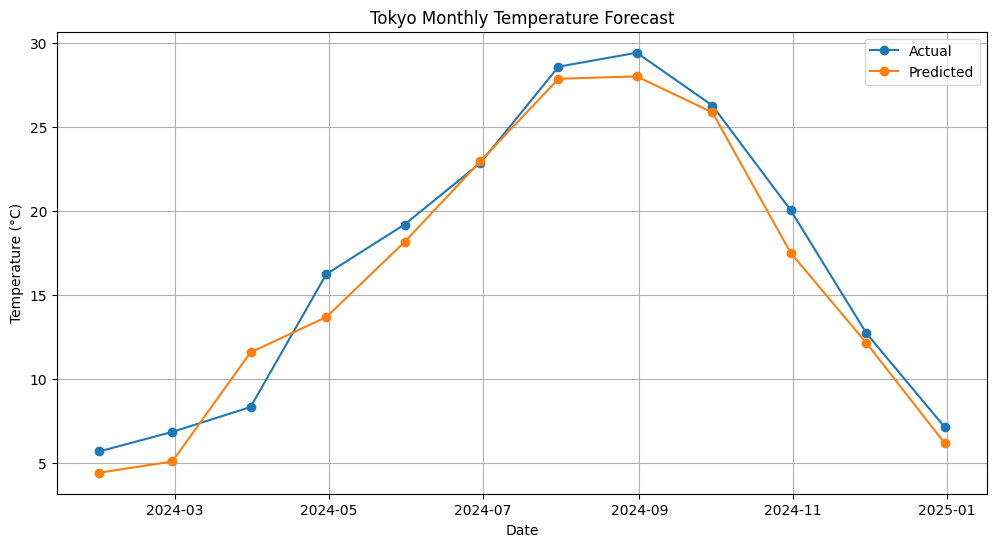

In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.append('date')

city_df = df[df['capital'] == "Tokyo"][numeric_cols].copy()

city_df['date'] = pd.to_datetime(city_df['date'])
city_df = city_df.set_index('date')

city_monthly = city_df.resample('ME').mean().reset_index()


#monthly mean values
city_monthly = city_df.resample('ME').mean().reset_index()


#(monthly)lag features
city_monthly['temp_lag1']  = city_monthly['temp_mean_c_approx'].shift(1)
city_monthly['temp_lag2']  = city_monthly['temp_mean_c_approx'].shift(2)
city_monthly['temp_lag12'] = city_monthly['temp_mean_c_approx'].shift(12)   # 1-year memory
city_monthly['temp_lag24'] = city_monthly['temp_mean_c_approx'].shift(24)   # 2-year memory


#(monthly)seasonal features
city_monthly['month'] = city_monthly['date'].dt.month


#feature list
features = [
    'temp_lag1', 'temp_lag2', 'temp_lag12', 'temp_lag24',
    'month',
    'precip_mm', 'rain_mm', 'shortwave_radiation_MJ_m2'
]

target = 'temp_mean_c_approx'


#train/test
clean = city_monthly.dropna()   # remove rows with lag NaNs
train = clean.iloc[:-12]        # all but last year
test  = clean.iloc[-12:]        # last year only

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


#train model
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
model.fit(X_train, y_train)


#predict
preds = model.predict(X_test)

#evaluate
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)

#actual vs predicted plot
plt.figure(figsize=(12,6))
plt.plot(test['date'], y_test, label='Actual', marker='o')
plt.plot(test['date'], preds, label='Predicted', marker='o')
plt.title("Tokyo Monthly Temperature Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


RMSE: 2.061614581020611
MAE : 1.6081214219135331


/tmp/ipython-input-980859152.py:89: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-980859152.py:90: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-980859152.py:91: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-980859152.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

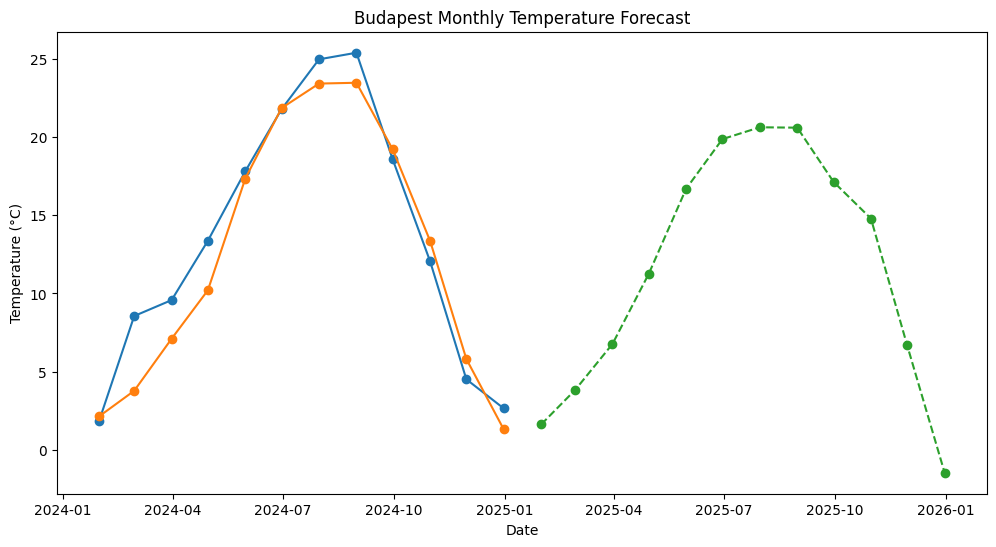

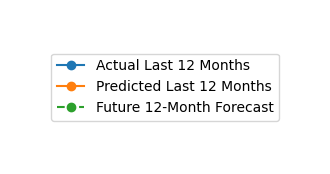

===== Temperature Summary (Last 12 Months) =====
Actual 12-month High:  25.40 °C
Actual 12-month Low:   1.86 °C

===== Future 12-Month Forecast Summary =====
Future High: 20.63 °C  (Month: 2025-07)
Future Low:  -1.47 °C  (Month: 2025-12)


In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.append('date')  # keep date

city_name = "Budapest" #CHANGE THIS TO EVALUATE DIFFERENT CITIES

city_df = df[df['capital'] == city_name].copy()
city_df['date'] = pd.to_datetime(city_df['date'])
numeric_cols = city_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.append('date')  #keep date so we can resample
city_df = city_df[numeric_cols].copy()
city_df = city_df.set_index('date')
city_monthly = city_df.resample('ME').mean().reset_index()


city_monthly['temp_lag1']  = city_monthly['temp_mean_c_approx'].shift(1)
city_monthly['temp_lag2']  = city_monthly['temp_mean_c_approx'].shift(2)
city_monthly['temp_lag12'] = city_monthly['temp_mean_c_approx'].shift(12)
city_monthly['temp_lag24'] = city_monthly['temp_mean_c_approx'].shift(24)
city_monthly['month'] = city_monthly['date'].dt.month

#seasonal encoding
city_monthly['month_sin'] = np.sin(2 * np.pi * city_monthly['month'] / 12)
city_monthly['month_cos'] = np.cos(2 * np.pi * city_monthly['month'] / 12)

features = [
    'temp_lag1', 'temp_lag2', 'temp_lag12', 'temp_lag24',
    'month', 'month_sin', 'month_cos',
    'precip_mm', 'rain_mm', 'shortwave_radiation_MJ_m2'
]


target = 'temp_mean_c_approx'


#train/test
clean = city_monthly.dropna()
train = clean.iloc[:-12]
test  = clean.iloc[-12:]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


#training the model
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)


#predict last 12 months - eval
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print("RMSE:", rmse)
print("MAE :", mae)

#create future 12-month date range
last_date = city_monthly['date'].max()
future_dates = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='ME')

forecast_df = pd.DataFrame({'date': future_dates})
forecast_df['month'] = forecast_df['date'].dt.month

history = clean.copy()
lag_source = history[['date', 'temp_mean_c_approx', 'precip_mm', 'rain_mm',
                      'shortwave_radiation_MJ_m2']].set_index('date')

future_predictions = []

for i in range(12):
    row_date = forecast_df.loc[i, 'date']
    row_month = forecast_df.loc[i, 'month']

    #values from history
    temp_lag1  = lag_source['temp_mean_c_approx'][-1]
    temp_lag2  = lag_source['temp_mean_c_approx'][-2]
    temp_lag12 = lag_source['temp_mean_c_approx'][-12]
    temp_lag24 = lag_source['temp_mean_c_approx'][-24]

    month_sin = np.sin(2 * np.pi * row_month / 12)
    month_cos = np.cos(2 * np.pi * row_month / 12)


    #use last known values
    precip_last = lag_source['precip_mm'].iloc[-1]
    rain_last   = lag_source['rain_mm'].iloc[-1]
    rad_last    = lag_source['shortwave_radiation_MJ_m2'].iloc[-1]

    #full feature vector
    X_future = pd.DataFrame([{
        'temp_lag1': temp_lag1,
        'temp_lag2': temp_lag2,
        'temp_lag12': temp_lag12,
        'temp_lag24': temp_lag24,
        'month': row_month,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'precip_mm': precip_last,
        'rain_mm': rain_last,
        'shortwave_radiation_MJ_m2': rad_last
    }])

    #predict
    pred = model.predict(X_future)[0]
    future_predictions.append(pred)
    lag_source.loc[row_date] = [pred, precip_last, rain_last, rad_last]


forecast_df['predicted_temp'] = future_predictions


plt.figure(figsize=(12,6))
plt.plot(test['date'], y_test, label='Actual Last 12 Months', marker='o')
plt.plot(test['date'], preds, label='Predicted Last 12 Months', marker='o')
plt.plot(forecast_df['date'], forecast_df['predicted_temp'],
         label='Future 12-Month Forecast', marker='o', linestyle='--')

plt.title(f"{city_name} Monthly Temperature Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
handles, labels = plt.gca().get_legend_handles_labels()
fig_legend = plt.figure(figsize=(4,2))
fig_legend.legend(handles, labels, loc='center')
plt.axis('off')

plt.grid(True)
plt.show()


#hghest & lowest values in actual last 12 months
actual_max = y_test.max()
actual_min = y_test.min()

print("===== Temperature Summary (Last 12 Months) =====")
print(f"Actual 12-month High:  {actual_max:.2f} °C")
print(f"Actual 12-month Low:   {actual_min:.2f} °C")
print()

# Highest & lowest temperatures in the future 12-month forecast
future_max = forecast_df['predicted_temp'].max()
future_min = forecast_df['predicted_temp'].min()

future_max_month = forecast_df.loc[forecast_df['predicted_temp'].idxmax(), 'date']
future_min_month = forecast_df.loc[forecast_df['predicted_temp'].idxmin(), 'date']

print("===== Future 12-Month Forecast Summary =====")
print(f"Future High: {future_max:.2f} °C  (Month: {future_max_month.strftime('%Y-%m')})")
print(f"Future Low:  {future_min:.2f} °C  (Month: {future_min_month.strftime('%Y-%m')})")




RMSE: 1.820898213048782
MAE : 1.521616277715329


/tmp/ipython-input-2130376718.py:77: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-2130376718.py:78: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-2130376718.py:79: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-2130376718.py:80: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

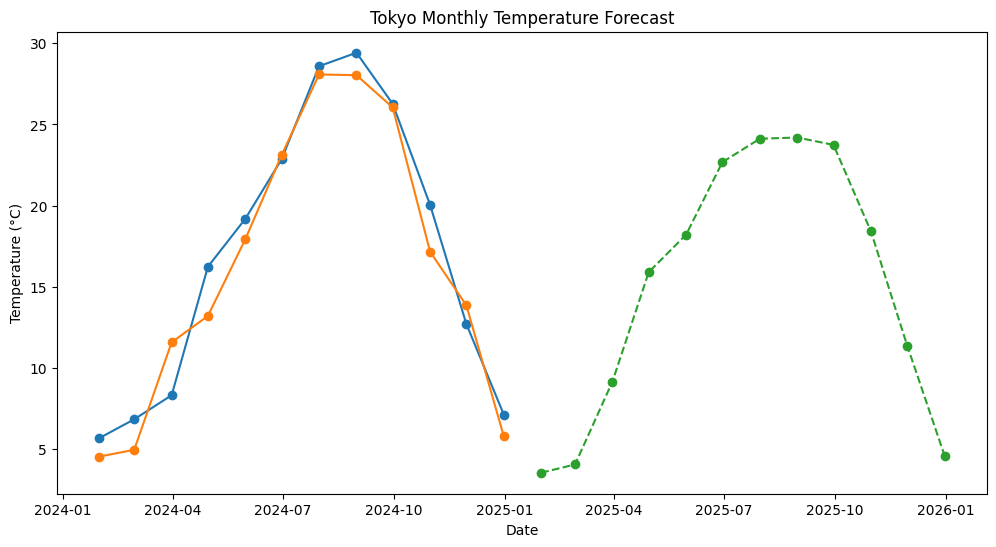

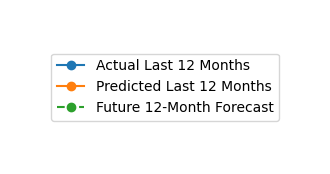

===== Temperature Summary (Last 12 Months) =====
Actual 12-month High:  29.41 °C
Actual 12-month Low:   5.69 °C

===== Future 12-Month Forecast Summary =====
Future High: 24.19 °C (Month: 2025-08)
Future Low:  3.56 °C (Month: 2025-01)


In [100]:
#XGBoostRegressor Model
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

city_name = "Tokyo"

city_df = df[df['capital'] == city_name].copy()
city_df['date'] = pd.to_datetime(city_df['date'])
numeric_cols = city_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.append('date')
city_df = city_df[numeric_cols].copy()
city_df = city_df.set_index('date')
city_monthly = city_df.resample('ME').mean().reset_index()

city_monthly['temp_lag1']  = city_monthly['temp_mean_c_approx'].shift(1)
city_monthly['temp_lag2']  = city_monthly['temp_mean_c_approx'].shift(2)
city_monthly['temp_lag12'] = city_monthly['temp_mean_c_approx'].shift(12)
city_monthly['temp_lag24'] = city_monthly['temp_mean_c_approx'].shift(24)

city_monthly['month'] = city_monthly['date'].dt.month
city_monthly['month_sin'] = np.sin(2 * np.pi * city_monthly['month'] / 12)
city_monthly['month_cos'] = np.cos(2 * np.pi * city_monthly['month'] / 12)

features = [
    'temp_lag1','temp_lag2','temp_lag12','temp_lag24',
    'month','month_sin','month_cos',
    'precip_mm','rain_mm','shortwave_radiation_MJ_m2'
]

target = 'temp_mean_c_approx'

clean = city_monthly.dropna()
train = clean.iloc[:-12]
test  = clean.iloc[-12:]

X_train = train[features]
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)

print("RMSE:", rmse)
print("MAE :", mae)

last_date = city_monthly['date'].max()
future_dates = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='ME')

forecast_df = pd.DataFrame({'date': future_dates})
forecast_df['month'] = forecast_df['date'].dt.month

history = clean.copy()
lag_source = history[['date','temp_mean_c_approx','precip_mm','rain_mm','shortwave_radiation_MJ_m2']].set_index('date')

future_predictions = []

for i in range(12):
    row_date = forecast_df.loc[i,'date']
    row_month = forecast_df.loc[i,'month']

    temp_lag1  = lag_source['temp_mean_c_approx'][-1]
    temp_lag2  = lag_source['temp_mean_c_approx'][-2]
    temp_lag12 = lag_source['temp_mean_c_approx'][-12]
    temp_lag24 = lag_source['temp_mean_c_approx'][-24]

    precip_last = lag_source['precip_mm'].iloc[-1]
    rain_last   = lag_source['rain_mm'].iloc[-1]
    rad_last    = lag_source['shortwave_radiation_MJ_m2'].iloc[-1]

    month_sin = np.sin(2 * np.pi * row_month / 12)
    month_cos = np.cos(2 * np.pi * row_month / 12)

    X_future = pd.DataFrame([{
        'temp_lag1': temp_lag1,
        'temp_lag2': temp_lag2,
        'temp_lag12': temp_lag12,
        'temp_lag24': temp_lag24,
        'month': row_month,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'precip_mm': precip_last,
        'rain_mm': rain_last,
        'shortwave_radiation_MJ_m2': rad_last
    }])

    pred = model.predict(X_future)[0]
    future_predictions.append(pred)
    lag_source.loc[row_date] = [pred, precip_last, rain_last, rad_last]

forecast_df['predicted_temp'] = future_predictions

plt.figure(figsize=(12,6))
plt.plot(test['date'], y_test, label='Actual Last 12 Months', marker='o')
plt.plot(test['date'], preds, label='Predicted Last 12 Months', marker='o')
plt.plot(forecast_df['date'], forecast_df['predicted_temp'], label='Future 12-Month Forecast', marker='o', linestyle='--')
plt.title(f"{city_name} Monthly Temperature Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")

handles, labels = plt.gca().get_legend_handles_labels()
fig_legend = plt.figure(figsize=(4,2))
fig_legend.legend(handles, labels, loc='center')
plt.axis('off')

plt.grid(True)
plt.show()

actual_max = y_test.max()
actual_min = y_test.min()

print("===== Temperature Summary (Last 12 Months) =====")
print(f"Actual 12-month High:  {actual_max:.2f} °C")
print(f"Actual 12-month Low:   {actual_min:.2f} °C")
print()

future_max = forecast_df['predicted_temp'].max()
future_min = forecast_df['predicted_temp'].min()

future_max_month = forecast_df.loc[forecast_df['predicted_temp'].idxmax(),'date']
future_min_month = forecast_df.loc[forecast_df['predicted_temp'].idxmin(),'date']

print("===== Future 12-Month Forecast Summary =====")
print(f"Future High: {future_max:.2f} °C (Month: {future_max_month.strftime('%Y-%m')})")
print(f"Future Low:  {future_min:.2f} °C (Month: {future_min_month.strftime('%Y-%m')})")
